### IMDB Reviews

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
import pandas as pd
import numpy as np
import csv
import random
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import tensorflow_datasets as tfds      # prebuilt datasets

imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)          # return data and metadata

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteA9YTMR/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteA9YTMR/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteA9YTMR/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
imdb

{'test': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>,
 'train': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>,
 'unsupervised': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>}

In [ ]:
train_data, test_data = imdb['train'], imdb['test']         # data split into 25k train, 25k test

In [ ]:
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

for s,l in train_data:            # s & l are tensors
    training_sentences.append(s.numpy().decode('utf8'))     # tensor -> numpy -> extracting sentences 
    training_labels.append(l.numpy())                       # tensor -> numpy -> extracting labels 
  
for s,l in test_data:
    testing_sentences.append(s.numpy().decode('utf8'))
    testing_labels.append(l.numpy())

In [ ]:
training_sentences[:2]

["This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
 'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development wa

In [ ]:
training_labels[:2]

[0, 0]

In [ ]:
len(training_sentences), len(training_labels)

(25000, 25000)

In [ ]:
len(testing_sentences), len(testing_labels)

(25000, 25000)

In [ ]:
type(training_labels)

list

In [ ]:
# when training, labels should be numpy arrays

training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [ ]:
vocab_size = 10000                      # number of unique words in the corpus
embedding_dim = 16                      # number of dimensions we wish to embed each word into
max_length = 120                        # maximum length of document/sentence

trunc_type = "post"                     
oov_tok = "<OOV>"                       # out of vocab words in test set will be marked OOV

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length)

In [ ]:
len(word_index)

88583

In [ ]:
num_classes = 1

In [ ]:
model = Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    layers.Flatten(),                              # or use GlobalAveragePooling1D
    layers.Dense(16, activation='relu'),
    layers.Dense(num_classes, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
flatten_4 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                30736     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 190,753
Trainable params: 190,753
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer   = tf.keras.optimizers.Adam(learning_rate=0.01)
loss        = tf.keras.losses.BinaryCrossentropy()
metrics     = ['accuracy']

In [ ]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [ ]:
early_stopping    = EarlyStopping(monitor='loss', patience=7)
reduce_lr         = ReduceLROnPlateau(monitor='loss', patience=7, min_lr=0.001, mode='min', verbose=1)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [ ]:
epochs = 20
callbacks = [early_stopping, reduce_lr, model_checkpoint]

In [ ]:
history = model.fit(training_padded,
                    training_labels,
                    validation_data=(testing_padded, testing_labels),
                    verbose = 1,
                    epochs = epochs,
                    callbacks = callbacks)

Epoch 1/20
782/782 [==============================] - 7s 8ms/step - loss: 0.4450 - accuracy: 0.7888 - val_loss: 0.3605 - val_accuracy: 0.8396
Epoch 2/20
782/782 [==============================] - 6s 8ms/step - loss: 0.2032 - accuracy: 0.9196 - val_loss: 0.4352 - val_accuracy: 0.8211
Epoch 3/20
782/782 [==============================] - 5s 7ms/step - loss: 0.0724 - accuracy: 0.9742 - val_loss: 0.6353 - val_accuracy: 0.8098
Epoch 4/20
782/782 [==============================] - 5s 6ms/step - loss: 0.0437 - accuracy: 0.9844 - val_loss: 0.8091 - val_accuracy: 0.8046
Epoch 5/20
782/782 [==============================] - 5s 6ms/step - loss: 0.0367 - accuracy: 0.9882 - val_loss: 0.9904 - val_accuracy: 0.7982
Epoch 6/20
782/782 [==============================] - 5s 6ms/step - loss: 0.0303 - accuracy: 0.9894 - val_loss: 0.9024 - val_accuracy: 0.8014
Epoch 7/20
782/782 [==============================] - 5s 6ms/step - loss: 0.0270 - accuracy: 0.9903 - val_loss: 1.1493 - val_accuracy: 0.8058
Epoch 

<Figure size 432x288 with 0 Axes>

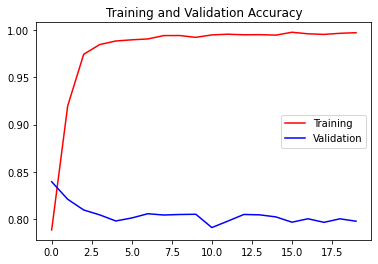

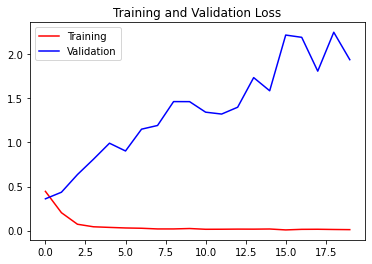

<Figure size 432x288 with 0 Axes>

In [ ]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']

epochs   = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training')
plt.plot(epochs, val_acc, 'b', label = 'Validation')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(loss))

plt.plot(epochs, loss, 'r', label = 'Training')
plt.plot(epochs, val_loss, 'b', label = 'Validation')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()

In [ ]:
# getting results of embedding layer

e = model.layers[0]             
weights = e.get_weights()[0]          # getting weights of that layer
print(weights.shape) # shape: (vocab_size (10k words in corpus), embedding_dim (16 dimensions))

(10000, 16)


In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])      # just reversing {Hello : 1} to {1 : Hello}

In [ ]:
# just checking out how it does decoding

print(training_sentences[0])                    # sample original sentence

def decode_review(text):                        # decoding the review
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(training_padded[0]))        # sample decoded sentence

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
? ? ? this was an absolutely terrible movie don't be <OOV> in by christopher walken or michael <OOV> both are great actors but this must simply be their worst role in history even their great acting could not redeem this movie's ridiculous storyline this movie is an early nineties us propa

In [ ]:
# code for getting vectors and metadata for tensorflow projector

import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")                                      # actual word associated with dimensions
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")   # write value of 16 dimensions per word
out_v.close()
out_m.close()

In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Sarcasm Dataset

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /content/sarcasm.json

--2021-10-11 18:14:39--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 74.125.140.128, 173.194.76.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/content/sarcasm.json’

/content/sarcasm.js 100%[===================>]   5.38M  --.-KB/s    in 0.04s   

2021-10-11 18:14:39 (146 MB/s) - ‘/content/sarcasm.json’ saved [5643545/5643545]



In [ ]:
with open("/content/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:                          # separating labels and sentences
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [ ]:
sentences[:3]

["former versace store clerk sues over secret 'black code' for minority shoppers",
 "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
 "mom starting to fear son's web series closest thing she will have to grandchild"]

In [ ]:
labels[:3]

[0, 0, 1]

In [ ]:
len(sentences), len(labels)

(26709, 26709)

In [ ]:
vocab_size = 10000
embedding_dim = 16
max_length = 100

trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>"
training_size = 20000         # 20000 for train, 6709 for test

In [ ]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [ ]:
# tokenize, sequencing, padding

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type)

In [ ]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)

testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [ ]:
len(word_index)

25637

In [ ]:
num_classes = 1

In [ ]:
model = Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    layers.GlobalAveragePooling1D(),                              # or use Flatten
    layers.Dense(24, activation='relu'),
    layers.Dense(num_classes, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer   = tf.keras.optimizers.Adam(learning_rate=0.01)
loss        = tf.keras.losses.BinaryCrossentropy()
metrics     = ['accuracy']

In [ ]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [ ]:
early_stopping    = EarlyStopping(monitor='loss', patience=7)
reduce_lr         = ReduceLROnPlateau(monitor='loss', patience=7, min_lr=0.001, mode='min', verbose=1)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [ ]:
epochs = 30
callbacks = [early_stopping, reduce_lr, model_checkpoint]

In [ ]:
history = model.fit(training_padded,
                    training_labels,
                    validation_data=(testing_padded, testing_labels),
                    verbose = 1,
                    epochs = epochs,
                    callbacks = callbacks)

Epoch 1/30
625/625 [==============================] - 7s 5ms/step - loss: 0.4365 - accuracy: 0.7799 - val_loss: 0.3682 - val_accuracy: 0.8378
Epoch 2/30
625/625 [==============================] - 3s 5ms/step - loss: 0.2581 - accuracy: 0.8932 - val_loss: 0.3605 - val_accuracy: 0.8451
Epoch 3/30
625/625 [==============================] - 3s 5ms/step - loss: 0.1941 - accuracy: 0.9236 - val_loss: 0.3847 - val_accuracy: 0.8422
Epoch 4/30
625/625 [==============================] - 3s 5ms/step - loss: 0.1663 - accuracy: 0.9364 - val_loss: 0.4790 - val_accuracy: 0.8138
Epoch 5/30
625/625 [==============================] - 3s 5ms/step - loss: 0.1338 - accuracy: 0.9502 - val_loss: 0.4698 - val_accuracy: 0.8353
Epoch 6/30
625/625 [==============================] - 3s 5ms/step - loss: 0.1154 - accuracy: 0.9565 - val_loss: 0.4379 - val_accuracy: 0.8271
Epoch 7/30
625/625 [==============================] - 3s 5ms/step - loss: 0.0998 - accuracy: 0.9623 - val_loss: 0.6403 - val_accuracy: 0.8240
Epoch 

<Figure size 432x288 with 0 Axes>

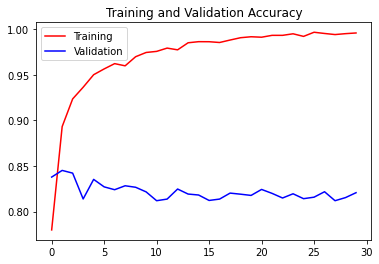

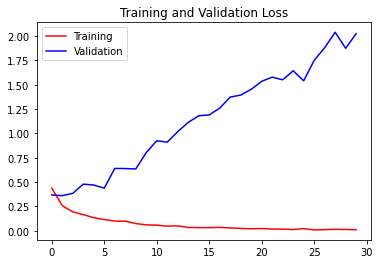

<Figure size 432x288 with 0 Axes>

In [ ]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']

epochs   = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training')
plt.plot(epochs, val_acc, 'b', label = 'Validation')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(loss))

plt.plot(epochs, loss, 'r', label = 'Training')
plt.plot(epochs, val_loss, 'b', label = 'Validation')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()

In [ ]:
sentence = ["granny starting to fear spiders in the garden might be real", 
            "game of thrones season finale showing this sunday night"]

sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(model.predict(padded))
print(np.argmax(model.predict(padded), axis=1))

[[6.9212886e-03]
 [4.2521169e-05]]
[0 0]


## Training on IMDB subwords

In [ ]:
# here the tokenization is done on sub words instead of words
# and this may give accuracy issues

import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete25S02I/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete25S02I/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete25S02I/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [ ]:
imdb

{'test': <PrefetchDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>,
 'train': <PrefetchDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>,
 'unsupervised': <PrefetchDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>}

In [ ]:
train_data, test_data = imdb['train'], imdb['test']

In [ ]:
tokenizer = info.features['text'].encoder

In [ ]:
tokenizer.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

In [ ]:
sample_string = 'TensorFlow, from basics to mastery'

tokenized_string = tokenizer.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print ('The original string: {}'.format(original_string))


Tokenized string is [6307, 2327, 4043, 2120, 2, 48, 4249, 4429, 7, 2652, 8050]
The original string: TensorFlow, from basics to mastery


In [ ]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
2 ----> , 
48 ----> from 
4249 ----> basi
4429 ----> cs 
7 ----> to 
2652 ----> master
8050 ----> y


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_data.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_dataset))
test_dataset = test_data.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_data))

In [ ]:
embedding_dim = 64
num_classes = 1

In [ ]:
model = Sequential([
    layers.Embedding(input_dim=tokenizer.vocab_size, output_dim=embedding_dim),
    layers.GlobalAveragePooling1D(),                              # or use Flatten
    layers.Dense(6, activation='relu'),
    layers.Dense(num_classes, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 524,237
Trainable params: 524,237
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer   = tf.keras.optimizers.Adam(learning_rate=0.01)
loss        = tf.keras.losses.BinaryCrossentropy()
metrics     = ['accuracy']

In [ ]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [ ]:
epochs = 10

In [ ]:
history = model.fit(train_dataset,
                    validation_data=test_dataset,
                    verbose = 1,
                    epochs = epochs)

Epoch 1/10
391/391 [==============================] - 8s 17ms/step - loss: 0.4922 - accuracy: 0.7446 - val_loss: 0.3236 - val_accuracy: 0.8644
Epoch 2/10
391/391 [==============================] - 7s 17ms/step - loss: 0.2555 - accuracy: 0.8999 - val_loss: 0.3236 - val_accuracy: 0.8644
Epoch 3/10
391/391 [==============================] - 7s 16ms/step - loss: 0.2074 - accuracy: 0.9175 - val_loss: 0.3085 - val_accuracy: 0.8756
Epoch 4/10
391/391 [==============================] - 7s 16ms/step - loss: 0.1799 - accuracy: 0.9312 - val_loss: 0.4164 - val_accuracy: 0.8412
Epoch 5/10
391/391 [==============================] - 7s 16ms/step - loss: 0.1586 - accuracy: 0.9379 - val_loss: 0.3603 - val_accuracy: 0.8637
Epoch 6/10
391/391 [==============================] - 7s 16ms/step - loss: 0.1460 - accuracy: 0.9424 - val_loss: 0.4515 - val_accuracy: 0.8477
Epoch 7/10
391/391 [==============================] - 7s 16ms/step - loss: 0.1228 - accuracy: 0.9522 - val_loss: 0.4611 - val_accuracy: 0.8598

<Figure size 432x288 with 0 Axes>

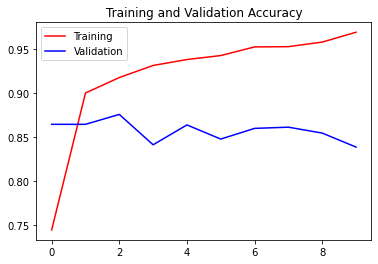

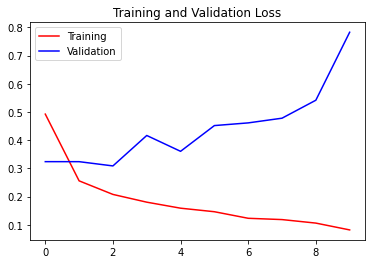

<Figure size 432x288 with 0 Axes>

In [ ]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']

epochs   = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training')
plt.plot(epochs, val_acc, 'b', label = 'Validation')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(loss))

plt.plot(epochs, loss, 'r', label = 'Training')
plt.plot(epochs, val_loss, 'b', label = 'Validation')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()

## Exercise 10

Running on BBC data.

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv \
    -O /content/bbc-text.csv

--2021-10-11 18:37:57--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.5.128, 64.233.184.128, 74.125.133.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.5.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [text/csv]
Saving to: ‘/content/bbc-text.csv’

/content/bbc-text.c 100%[===================>]   4.82M  29.1MB/s    in 0.2s    

2021-10-11 18:37:58 (29.1 MB/s) - ‘/content/bbc-text.csv’ saved [5057493/5057493]



In [ ]:
df = pd.read_csv('bbc-text.csv')
df.shape

(2225, 2)

In [ ]:
df.head(10)

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
5,politics,howard hits back at mongrel jibe michael howar...
6,politics,blair prepares to name poll date tony blair is...
7,sport,henman hopes ended in dubai third seed tim hen...
8,sport,wilkinson fit to face edinburgh england captai...
9,entertainment,last star wars not for children the sixth an...


In [ ]:
df['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [ ]:
vocab_size = 10000
embedding_dim = 16
max_length = 100

trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>"
training_portion = 0.8

In [ ]:
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
print(len(stopwords))

153


In [ ]:
sentences = []
labels = []

with open("/content/bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        sentence = row[1]
        for word in stopwords:
            token = " " + word + " "
            sentence = sentence.replace(token, " ")
        sentences.append(sentence)

In [ ]:
len(labels), len(sentences)

(2225, 2225)

In [ ]:
sentences[0][:20]

'tv future hands view'

In [ ]:
training_size = int(len(sentences) * training_portion)

training_sentences = sentences[:training_size]
training_labels = labels[:training_size]

testing_sentences = sentences[training_size:]
testing_labels = labels[training_size:]

print(training_size)
print(len(training_sentences))
print(len(training_labels))
print(len(testing_sentences))
print(len(testing_labels))

1780
1780
1780
445
445


In [ ]:
# tokenize, sequencing, padding

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type)

In [ ]:
print(len(training_sequences[0]), len(training_padded[0]))
print(len(training_sequences[1]), len(training_padded[1]))
print(len(training_sequences[10]), len(training_padded[10]))

449 100
200 100
192 100


In [ ]:
print(len(testing_sequences))
print(testing_padded.shape)

445
(445, 100)


In [ ]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(training_labels))
testing_label_seq = np.array(label_tokenizer.texts_to_sequences(testing_labels))

print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(testing_label_seq[0])
print(testing_label_seq[1])
print(testing_label_seq[2])
print(testing_label_seq.shape)

[4]
[2]
[1]
(1780, 1)
[5]
[4]
[3]
(445, 1)


In [ ]:
num_classes = 6

In [ ]:
model = Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    layers.GlobalAveragePooling1D(),                              # or use Flatten
    layers.Dense(24, activation='relu'),
    layers.Dense(num_classes, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 150       
Total params: 160,558
Trainable params: 160,558
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer   = tf.keras.optimizers.Adam(learning_rate=0.01)
loss        = tf.keras.losses.SparseCategoricalCrossentropy()
metrics     = ['accuracy']

In [ ]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [ ]:
early_stopping    = EarlyStopping(monitor='loss', patience=7)
reduce_lr         = ReduceLROnPlateau(monitor='loss', patience=7, min_lr=0.001, mode='min', verbose=1)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [ ]:
epochs = 50
callbacks = [early_stopping, reduce_lr, model_checkpoint]

In [ ]:
history = model.fit(training_padded,
                    training_label_seq,
                    validation_data=(testing_padded, testing_label_seq),
                    verbose = 1,
                    epochs = epochs,
                    callbacks = callbacks)

Epoch 1/50
56/56 [==============================] - 1s 8ms/step - loss: 1.2507 - accuracy: 0.5781 - val_loss: 0.5686 - val_accuracy: 0.8629
Epoch 2/50
56/56 [==============================] - 0s 6ms/step - loss: 0.1352 - accuracy: 0.9753 - val_loss: 0.2882 - val_accuracy: 0.8944
Epoch 3/50
56/56 [==============================] - 0s 6ms/step - loss: 0.0120 - accuracy: 0.9989 - val_loss: 0.2591 - val_accuracy: 0.9034
Epoch 4/50
56/56 [==============================] - 0s 6ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.2573 - val_accuracy: 0.9034
Epoch 5/50
56/56 [==============================] - 0s 5ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.2567 - val_accuracy: 0.9079
Epoch 6/50
56/56 [==============================] - 0s 6ms/step - loss: 9.6869e-04 - accuracy: 1.0000 - val_loss: 0.2572 - val_accuracy: 0.9101
Epoch 7/50
56/56 [==============================] - 0s 6ms/step - loss: 6.7626e-04 - accuracy: 1.0000 - val_loss: 0.2601 - val_accuracy: 0.9124
Epoch 8/50
5

<Figure size 432x288 with 0 Axes>

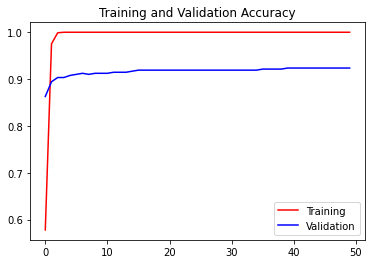

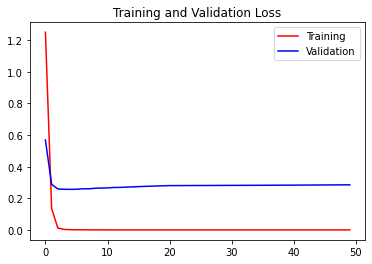

<Figure size 432x288 with 0 Axes>

In [ ]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']

epochs   = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training')
plt.plot(epochs, val_acc, 'b', label = 'Validation')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(loss))

plt.plot(epochs, loss, 'r', label = 'Training')
plt.plot(epochs, val_loss, 'b', label = 'Validation')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()